Building an Image Classifier using CNN

#Setup

In [53]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
np.random.seed(42)
import matplotlib as mpl
import matplotlib.pyplot as plt

# our imports
import kagglehub
import os
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


In [54]:
path = kagglehub.dataset_download("alessiocorrado99/animals10")

# using 128x128 for our scratch model
train_ds_128 = image_dataset_from_directory(f"{path}/raw-img", validation_split=0.2,subset="training",seed=67,image_size=(128, 128),batch_size=32)
test_ds_128 = image_dataset_from_directory(f"{path}/raw-img",validation_split=0.2,subset="validation",seed=67,image_size=(128, 128),batch_size=32)

# using 224x224 for our transfer model since 224 is the standard for pretrained models
train_ds_224 = image_dataset_from_directory(f"{path}/raw-img", validation_split=0.2,subset="training",seed=67,image_size=(224, 224),batch_size=32)
test_ds_224 = image_dataset_from_directory(f"{path}/raw-img",validation_split=0.2,subset="validation",seed=67,image_size=(224, 224),batch_size=32)

Using Colab cache for faster access to the 'animals10' dataset.
Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


# Build a neural network model

Model from Scratch

In [55]:
scratch = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),

    # need to change the images so that the model does not memorize them
    tf.keras.layers.Rescaling(1./255), # normalize the image for model to learn efficiently
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),

    tf.keras.layers.Conv2D(32, 3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, 3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(256, 3, padding="same"), # enough layers for model to find patterns
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])

Model w/ Transfer Learning

In [56]:
base_model = tf.keras.applications.EfficientNetB1(input_shape=(224, 224, 3),include_top=False,weights="imagenet")
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False # make last layer trainable to fine tune base model for animals10

transfer = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input), # also normalizes the images but specifically for imagenet
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation="softmax")
])



In [57]:
scratch.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 128, 128, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_4 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_4               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             

 Total params: 424,522 (1.62 MB)

 Trainable params: 423,562 (1.62 MB)

 Non-trainable params: 960 (3.75 KB)

In [58]:
transfer.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_5 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_5               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb1 (Functional)     │ (None, 7, 7, 1280)     │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,740,497 (25.71 MB)

 Trainable params: 2,637,066 (10.06 MB)

 Non-trainable params: 4,103,431 (15.65 MB)

#compiling the model:


In [59]:
scratch.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(3e-4),
              metrics=["accuracy"])

In [60]:
transfer.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(1e-5), # smaller learning rate since the model already has pretrained weights
              metrics=["accuracy"])

# training neural network model:


In [61]:
early_stop = tf.keras.callbacks.EarlyStopping( # stop early if loss doesnt lower
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint( # keep the best acc model by the end
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [62]:
history_s = scratch.fit(train_ds_128, batch_size = 32, epochs=100, validation_data=test_ds_128, callbacks=[early_stop])

Epoch 1/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.2779 - loss: 2.0772 - val_accuracy: 0.3551 - val_loss: 1.9335
Epoch 2/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4281 - loss: 1.6600 - val_accuracy: 0.3734 - val_loss: 1.8282
Epoch 3/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.4842 - loss: 1.4961 - val_accuracy: 0.2730 - val_loss: 2.1792
Epoch 4/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5190 - loss: 1.4005 - val_accuracy: 0.3847 - val_loss: 1.9108
Epoch 5/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5410 - loss: 1.3242 - val_accuracy: 0.3513 - val_loss: 1.8032
Epoch 6/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5667 - loss: 1.2714 - val_accuracy: 0.4860 - val_loss: 1.5186
Epoch 7/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5870 - loss: 1.2066 - val_accuracy: 0.4525 - val_loss: 1.5767
Epoch 8/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5993 - loss: 1

In [63]:
history_t = transfer.fit(train_ds_224, batch_size = 32, epochs=5, validation_data=test_ds_224)

Epoch 1/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4305 - loss: 1.8483 - val_accuracy: 0.9352 - val_loss: 0.5976
Epoch 2/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.8912 - loss: 0.5985 - val_accuracy: 0.9614 - val_loss: 0.2524
Epoch 3/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.9314 - loss: 0.3281 - val_accuracy: 0.9702 - val_loss: 0.1703
Epoch 4/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.9401 - loss: 0.2566 - val_accuracy: 0.9736 - val_loss: 0.1390
Epoch 5/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.9483 - loss: 0.2176 - val_accuracy: 0.9754 - val_loss: 0.1232


#Evaluation



In [64]:
score_s = scratch.evaluate(test_ds_128)

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7421 - loss: 0.7698


In [65]:
score_t = transfer.evaluate(test_ds_224)

164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9755 - loss: 0.1167


In [66]:
print('Total loss on Testing Set w/ Scratch Model:', score_s[0])
print('Accuracy of Testing Set: w/ Scratch Model', score_s[1])

Total loss on Testing Set w/ Scratch Model: 0.7992409467697144
Accuracy of Testing Set: w/ Scratch Model 0.7337153553962708


In [67]:
print('Total loss on Testing Set w/ Transfer Model:', score_t[0])
print('Accuracy of Testing Set: w/ Transfer Model', score_t[1])

Total loss on Testing Set w/ Transfer Model: 0.12315484136343002
Accuracy of Testing Set: w/ Transfer Model 0.9753581881523132


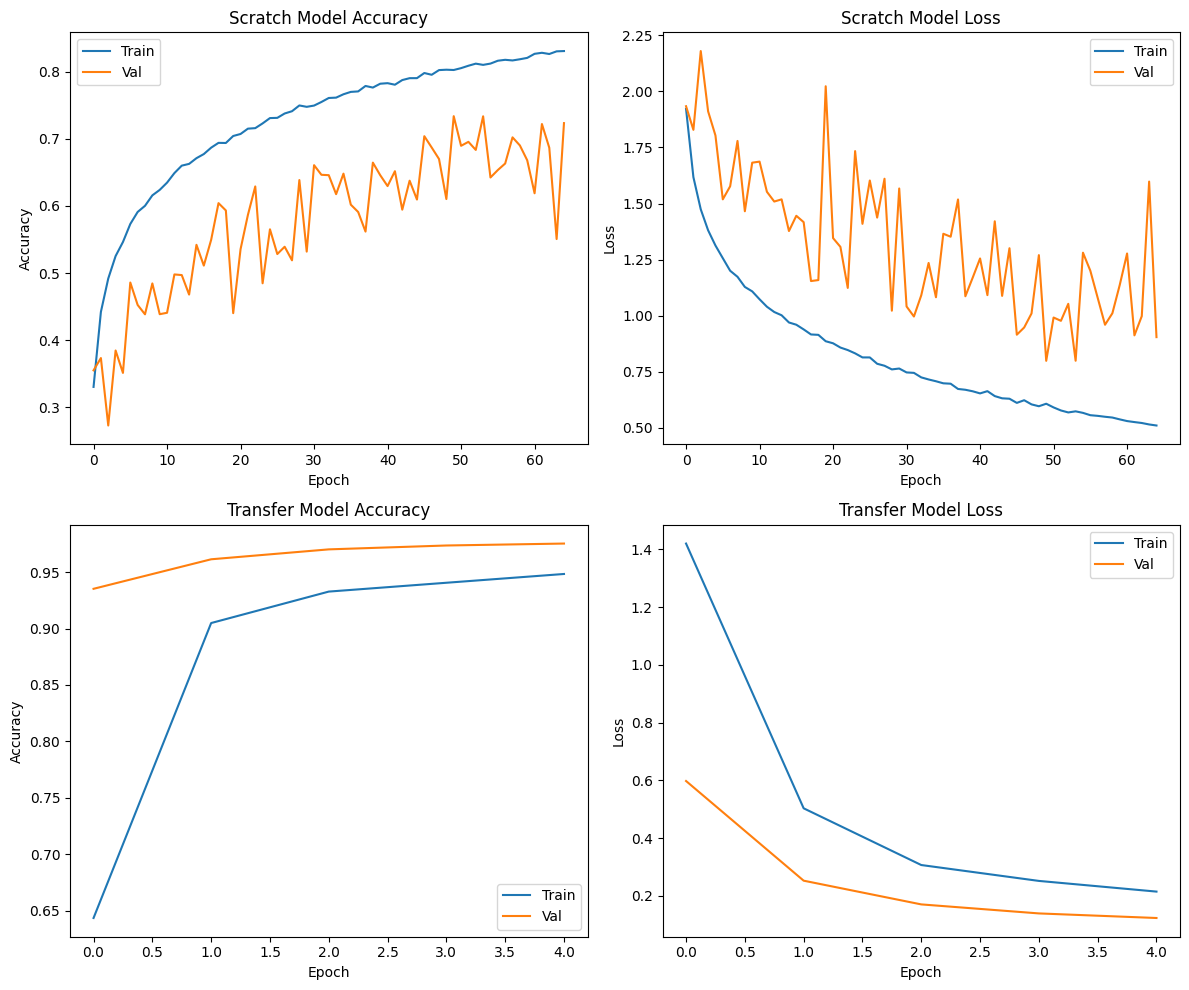

In [68]:
plt.figure(figsize=(12, 10))

# scratch
plt.subplot(2, 2, 1)
plt.plot(history_s.history['accuracy'], label='Train')
plt.plot(history_s.history['val_accuracy'], label='Val')
plt.title('Scratch Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history_s.history['loss'], label='Train')
plt.plot(history_s.history['val_loss'], label='Val')
plt.title('Scratch Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# transfer
plt.subplot(2, 2, 3)
plt.plot(history_t.history['accuracy'], label='Train')
plt.plot(history_t.history['val_accuracy'], label='Val')
plt.title('Transfer Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history_t.history['loss'], label='Train')
plt.plot(history_t.history['val_loss'], label='Val')
plt.title('Transfer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

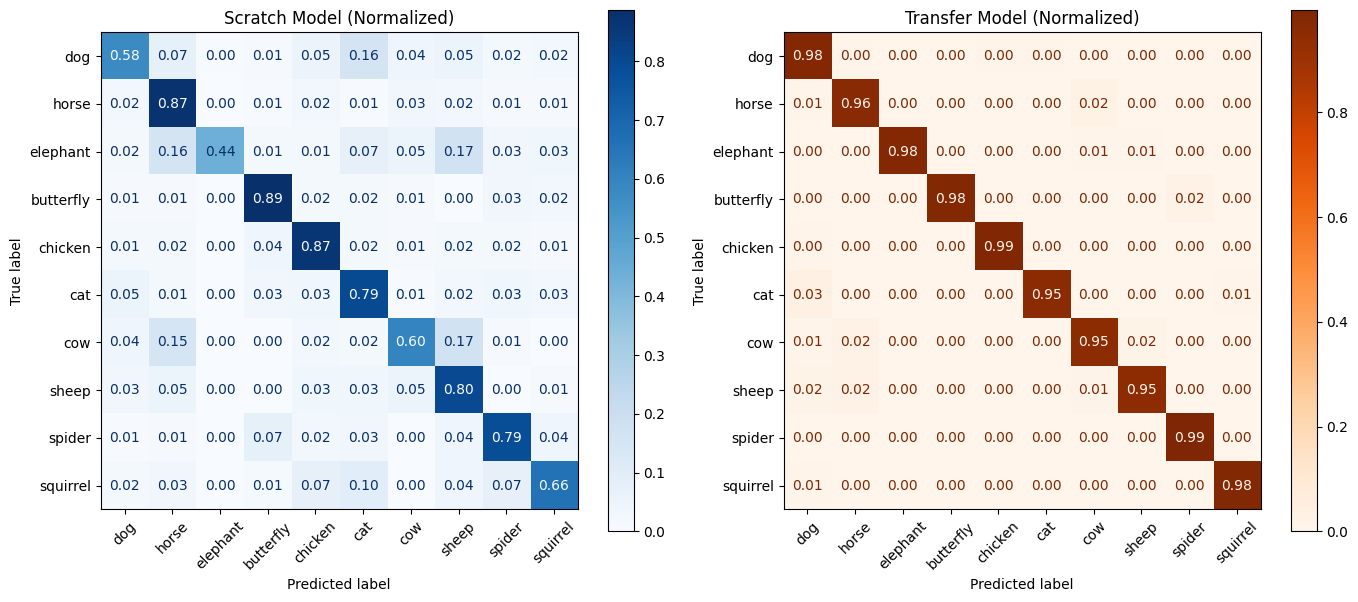

In [69]:
assert train_ds_128.class_names == train_ds_224.class_names, \
    "Class order mismatch between datasets!"

base_class_names = train_ds_128.class_names

translate = {"cane": "dog","cavallo": "horse","elefante": "elephant","farfalla": "butterfly","gallina": "chicken","gatto": "cat","mucca": "cow","pecora": "sheep","ragno": "spider","scoiattolo": "squirrel",}
class_names = [translate.get(c, c) for c in base_class_names]

def get_preds_labels(model, dataset):
    y_true, y_pred = [], []

    for x, y in dataset:
        preds = model.predict(x, verbose=0)
        y_pred.append(np.argmax(preds, axis=1))

        if y.ndim == 2:
            y_true.append(np.argmax(y.numpy(), axis=1))
        else:
            y_true.append(y.numpy())

    return np.concatenate(y_true), np.concatenate(y_pred)

y_true_s, y_pred_s = get_preds_labels(scratch, test_ds_128)
y_true_t, y_pred_t = get_preds_labels(transfer, test_ds_224)

cm_s = confusion_matrix(y_true_s, y_pred_s, normalize="true")
cm_t = confusion_matrix(y_true_t, y_pred_t, normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ConfusionMatrixDisplay(cm_s, display_labels=class_names).plot(
    ax=axes[0], cmap="Blues", xticks_rotation=45, values_format=".2f"
)
axes[0].set_title("Scratch Model (Normalized)")

ConfusionMatrixDisplay(cm_t, display_labels=class_names).plot(
    ax=axes[1], cmap="Oranges", xticks_rotation=45, values_format=".2f"
)
axes[1].set_title("Transfer Model (Normalized)")

plt.tight_layout()
plt.show()

In [70]:
labels = np.arange(len(class_names))
print('--------------------Scratch Model--------------------')
print(classification_report(y_true_s,y_pred_s,labels=labels,target_names=class_names,digits=4,zero_division=0))
print('--------------------Transfer Model--------------------')
print(classification_report(y_true_t,y_pred_t,labels=labels,target_names=class_names,digits=4,zero_division=0))

--------------------Scratch Model--------------------
              precision    recall  f1-score   support

         dog     0.8780    0.5777    0.6969       997
       horse     0.6686    0.8729    0.7572       527
    elephant     0.9685    0.4393    0.6044       280
   butterfly     0.7469    0.8867    0.8108       406
     chicken     0.7870    0.8651    0.8242       645
         cat     0.5009    0.7943    0.6144       350
         cow     0.6852    0.5968    0.6379       372
       sheep     0.5574    0.7984    0.6565       377
      spider     0.8877    0.7861    0.8338       935
    squirrel     0.6994    0.6590    0.6786       346

    accuracy                         0.7337      5235
   macro avg     0.7380    0.7276    0.7115      5235
weighted avg     0.7683    0.7337    0.7332      5235

--------------------Transfer Model--------------------
              precision    recall  f1-score   support

         dog     0.9692    0.9789    0.9741       997
       horse     0.9584

#Predicting the first three images from the test set


1.   print the predicted results of the first three images from the test set
2.   print the real label of the first three images from the test set



In [71]:
for images, labels in test_ds_128.take(1):
    X_new_s = images[:3]
    y_true_s = labels[:3]
y_proba_s = scratch.predict(X_new_s)
y_proba_s.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


array([[0.24, 0.07, 0.02, 0.01, 0.01, 0.01, 0.03, 0.14, 0.46, 0.02],
       [0.08, 0.  , 0.  , 0.01, 0.06, 0.83, 0.  , 0.  , 0.  , 0.01],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [72]:
for images, labels in test_ds_224.take(1):
    X_new_t = images[:3]
    y_true_t = labels[:3]
y_proba_t = transfer.predict(X_new_t)
y_proba_t.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([[0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [73]:
y_proba_s = scratch.predict(X_new_s)
y_pred_s = np.argmax(y_proba_s, axis=-1)
y_pred_s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


array([8, 5, 5])

In [74]:
y_proba_t = transfer.predict(X_new_t)
y_pred_t = np.argmax(y_proba_t, axis=-1)
y_pred_t

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([1, 3, 5])

In [75]:
it_class_names = train_ds_224.class_names
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "ragno": "spider", "squirrel": "scoiattolo"}
class_names = [translate.get(name, name) for name in it_class_names]
class_names

['dog',
 'horse',
 'elephant',
 'butterfly',
 'chicken',
 'cat',
 'cow',
 'sheep',
 'spider',
 'squirrel']

In [76]:
print(np.array(class_names)[y_pred_s])
print(np.array(class_names)[y_pred_t])

['spider' 'cat' 'cat']
['horse' 'butterfly' 'cat']


In [77]:
print(y_true_s)
print(y_true_t)

tf.Tensor([8 0 5], shape=(3,), dtype=int32)
tf.Tensor([1 3 5], shape=(3,), dtype=int32)


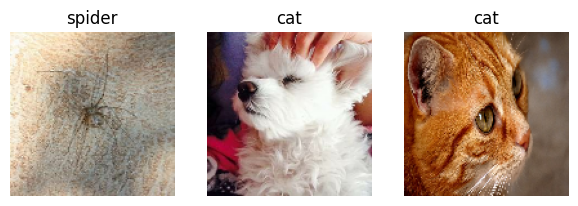

In [78]:
# scratch
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new_s):
    plt.subplot(1, 3, index + 1)

    img = image / 255.0

    plt.imshow(img)
    plt.axis('off')
    plt.title(class_names[y_pred_s[index]], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

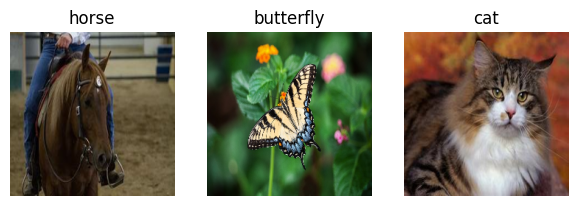

In [79]:
# transfer
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new_t):
    plt.subplot(1, 3, index + 1)

    img = image / 255.0

    plt.imshow(img)
    plt.axis('off')
    plt.title(class_names[y_pred_t[index]], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()